# Training the CF explainer and getting a CF example

Note: this code is a duplicate from the other one, but the difference is that in this notebook, uniform initialization is used.

In [1]:
# first import the needed packages
import torch
import numpy as np
from gcn import *
from gcn_perturbation_matrix import *
from sklearn.metrics import accuracy_score
from explainer_framework import *
from calculate_metrics import *
import pickle

/Users/janneke/opt/anaconda3/envs/CF-GNNExplainer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in the data we are working with:

In [2]:
with open('data/syn1.pickle','rb') as pickle_file: 
    data_syn1 = pickle.load(pickle_file)

with open('data/syn4.pickle','rb') as pickle_file:
    data_syn4 = pickle.load(pickle_file)
    
with open('data/syn5.pickle','rb') as pickle_file:
    data_syn5 = pickle.load(pickle_file)

### Put data into tensors

In [3]:
# squeeze the labels (as it has a singleton dim and then make it a tensor)
labels_syn1 = np.squeeze(data_syn1['labels'])
labels_syn1 = torch.tensor(labels_syn1)

labels_syn4 = np.squeeze(data_syn4['labels'])
labels_syn4 = torch.tensor(labels_syn4)

labels_syn5 = np.squeeze(data_syn5['labels'])
labels_syn5 = torch.tensor(labels_syn5)

# same for features, but define the type of data here
features_syn1 = np.squeeze(data_syn1['feat'])
features_syn1 = torch.tensor(features_syn1, dtype=torch.float)

features_syn4 = np.squeeze(data_syn4['feat'])
features_syn4 = torch.tensor(features_syn4, dtype=torch.float)

features_syn5 = np.squeeze(data_syn5['feat'])
features_syn5 = torch.tensor(features_syn5, dtype=torch.float)

# adjacency matrix
adjacency_matrix_syn1 = torch.tensor(np.squeeze(data_syn1['adj']), dtype=torch.float)
adjacency_matrix_syn4 = torch.tensor(np.squeeze(data_syn4['adj']), dtype=torch.float)
adjacency_matrix_syn5 = torch.tensor(np.squeeze(data_syn5['adj']), dtype=torch.float)

# the indices are already a list --> but have to split the training data in training and validation data first
train_indices_full_syn1 = torch.tensor(data_syn1['train_idx'])
train_indices_full_syn4 = torch.tensor(data_syn4['train_idx'])
train_indices_full_syn5 = torch.tensor(data_syn5['train_idx'])

# split in training and validation indices
train_indices_syn1, validation_indices_syn1 = torch.utils.data.random_split(train_indices_full_syn1, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_indices_syn4, validation_indices_syn4 = torch.utils.data.random_split(train_indices_full_syn4, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_indices_syn5, validation_indices_syn5 = torch.utils.data.random_split(train_indices_full_syn5, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

test_indices_syn1 = torch.tensor(data_syn1['test_idx'])
test_indices_syn4 = torch.tensor(data_syn4['test_idx'])
test_indices_syn5 = torch.tensor(data_syn5['test_idx'])

### Get the original models

In [4]:
model_syn1 = torch.load('models_newinit/syn1model.pt')
model_syn4 = torch.load('models_newinit/syn4model.pt')
model_syn5 = torch.load('models_newinit/syn5model.pt')

### First, get the original predictions for the model we're researching

In [5]:
model_syn1.eval()
sparse_adj_1 = get_sparse_adjacency_normalized(features_syn1.shape[0], adjacency_matrix_syn1)
outputs_syn1 = model_syn1(features_syn1, sparse_adj_1)

# print accuracy too (to check that it is the same as in the original)
_, predictions_1 = torch.max(outputs_syn1.data, 1)
print("Test accuracy of Syn1 data: ", accuracy_score(labels_syn1[test_indices_syn1], predictions_1[test_indices_syn1]))

model_syn4.eval()
sparse_adj_4 = get_sparse_adjacency_normalized(features_syn4.shape[0], adjacency_matrix_syn4)
outputs_syn4 = model_syn4(features_syn4, sparse_adj_4)

# print accuracy too (to check that it is the same as in the original)
_, predictions_4 = torch.max(outputs_syn4.data, 1)
print("Test accuracy of Syn4 data: ", accuracy_score(labels_syn4[test_indices_syn4], predictions_4[test_indices_syn4]))

model_syn5.eval()
sparse_adj_5 = get_sparse_adjacency_normalized(features_syn5.shape[0], adjacency_matrix_syn5)
outputs_syn5 = model_syn5(features_syn5, sparse_adj_5)

# print accuracy too (to check that it is the same as in the original)
_, predictions_5 = torch.max(outputs_syn5.data, 1)
print("Test accuracy of Syn5 data: ", accuracy_score(labels_syn5[test_indices_syn5], predictions_5[test_indices_syn5]))

Test accuracy of Syn1 data:  0.9928571428571429
Test accuracy of Syn4 data:  0.9142857142857143
Test accuracy of Syn5 data:  0.8623481781376519


/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn.py:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/torch/csrc/utils/tensor_new.cpp:233.)
  A_hat = torch.sparse_coo_tensor((A_hat.row, A_hat.col), A_hat.data, dtype=torch.float)


### Get the weights and biases for the models

In [6]:
layer1_W_syn1 = model_syn1.gcn_layer_1.W.detach()
layer1_b_syn1 = model_syn1.gcn_layer_1.b.detach()
layer2_W_syn1 = model_syn1.gcn_layer_2.W.detach()
layer2_b_syn1 = model_syn1.gcn_layer_2.b.detach()
layer3_W_syn1 = model_syn1.gcn_layer_3.W.detach()
layer3_b_syn1 = model_syn1.gcn_layer_3.b.detach()
lin_weight_syn1 = model_syn1.linear_layer.weight.detach()
lin_b_syn1 = model_syn1.linear_layer.bias.detach()

layer1_W_syn4 = model_syn4.gcn_layer_1.W.detach()
layer1_b_syn4 = model_syn4.gcn_layer_1.b.detach()
layer2_W_syn4 = model_syn4.gcn_layer_2.W.detach()
layer2_b_syn4 = model_syn4.gcn_layer_2.b.detach()
layer3_W_syn4 = model_syn4.gcn_layer_3.W.detach()
layer3_b_syn4 = model_syn4.gcn_layer_3.b.detach()
lin_weight_syn4 = model_syn4.linear_layer.weight.detach()
lin_b_syn4 = model_syn4.linear_layer.bias.detach()

layer1_W_syn5 = model_syn5.gcn_layer_1.W.detach()
layer1_b_syn5 = model_syn5.gcn_layer_1.b.detach()
layer2_W_syn5 = model_syn5.gcn_layer_2.W.detach()
layer2_b_syn5 = model_syn5.gcn_layer_2.b.detach()
layer3_W_syn5 = model_syn5.gcn_layer_3.W.detach()
layer3_b_syn5 = model_syn5.gcn_layer_3.b.detach()
lin_weight_syn5 = model_syn5.linear_layer.weight.detach()
lin_b_syn5 = model_syn5.linear_layer.bias.detach()

### Set up structure to get CF-examples (new perturbed GCN for every node we get a CF-explanation for!)
As subgraphs may have different sizes--> first get subgraph, then we know how big the perturbation matrix should be.

## Train it and get the CF-examples - Syn1

In [7]:
examples_all_syn1 = []
train_loss_all_syn1 = []
adjacency_neigh_syn1 = []
mapping_syn1 = []
nr_cf_syn1 = 0

for index in test_indices_syn1: 
    # get the old prediction
    old_prediction = predictions_1[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn1, features_syn1, adjacency_matrix_syn1)
    
    new_index = vertex_mapping[index.item()]
    
    # test whether it gets the same outcome
    sparse_adj_test = get_sparse_adjacency_normalized(features_perturbed.shape[0], adjacency_matrix)
    with torch.no_grad():
        outputs_test = model_syn1(features_perturbed, sparse_adj_test)

    # get accuracy too (to check that it is the same as in the original)
    _, predictions_test = torch.max(outputs_test.data, 1)
    
    # as a small test:
    assert predictions_test[new_index].item() == old_prediction, "wrong prediction"
        
    # make a gcn model (to use for perturbation):
    model_pert = GCNPerturbed(layer1_W_syn1, layer1_b_syn1, layer2_W_syn1, layer2_b_syn1, layer3_W_syn1, layer3_b_syn1, lin_weight_syn1, lin_b_syn1, adjacency_matrix.shape[0], "uniform")
    
    # from the model hyperparams:
    alpha = 0.1
    optim = torch.optim.SGD(model_pert.parameters(), lr=alpha, nesterov=True, momentum=0.9)
    beta = 0.5
    k = 500
    
    # get the new cf example!
    examples_for_index, train_loss = get_cf_example(new_index, old_prediction, model_pert, optim, beta, k, adjacency_matrix, labels_perturbed, features_perturbed)
    
    # append to all examples!!
    examples_all_syn1.append(examples_for_index)
    train_loss_all_syn1.append(train_loss)
    adjacency_neigh_syn1.append(adjacency_matrix)
    mapping_syn1.append(vertex_mapping)
    
    # add one if a counterfactual example was found for this index
    if examples_for_index != []:
        nr_cf_syn1 = nr_cf_syn1 + 1

/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn_perturbation_matrix.py:187: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nll_loss_part = nll_loss(F.log_softmax(output_g), target=prediction_original)


## Train it and get the CF-examples - Syn4

In [8]:
examples_all_syn4 = []
train_loss_all_syn4 = []
adjacency_neigh_syn4 = []
mapping_syn4 = []
nr_cf_syn4 = 0

for index in test_indices_syn4: 
    # get the old prediction
    old_prediction = predictions_4[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn4, features_syn4, adjacency_matrix_syn4)
    
    new_index = vertex_mapping[index.item()]
    
    # test whether it gets the same outcome
    sparse_adj_test = get_sparse_adjacency_normalized(features_perturbed.shape[0], adjacency_matrix)
    with torch.no_grad():
        outputs_test = model_syn4(features_perturbed, sparse_adj_test)

    # get accuracy too (to check that it is the same as in the original)
    _, predictions_test = torch.max(outputs_test.data, 1)
    
    # as a small test:
    assert predictions_test[new_index].item() == old_prediction, "wrong prediction"
        
    # make a gcn model (to use for perturbation):
    model_pert = GCNPerturbed(layer1_W_syn4, layer1_b_syn4, layer2_W_syn4, layer2_b_syn4, layer3_W_syn4, layer3_b_syn4, lin_weight_syn4, lin_b_syn4, adjacency_matrix.shape[0], "uniform")
    
    # from the model hyperparams:
    alpha = 0.1
    optim = torch.optim.SGD(model_pert.parameters(), lr=alpha)
    beta = 0.5
    k = 500
    
    # get the new cf example!
    examples_for_index, train_loss = get_cf_example(new_index, old_prediction, model_pert, optim, beta, k, adjacency_matrix, labels_perturbed, features_perturbed)
    
    # append to all examples!!
    examples_all_syn4.append(examples_for_index)
    train_loss_all_syn4.append(train_loss)
    adjacency_neigh_syn4.append(adjacency_matrix)
    mapping_syn4.append(vertex_mapping)
    
    # add one if a counterfactual example was found for this index
    if examples_for_index != []:
        nr_cf_syn4 = nr_cf_syn4 + 1

## Train it and get the CF-examples - Syn5

In [9]:
examples_all_syn5 = []
train_loss_all_syn5 = []
nr_cf_syn5 = 0
adjacency_neigh_syn5 = []
mapping_syn5 = []

for index in test_indices_syn5: 
    # get the old prediction
    old_prediction = predictions_5[index.item()]
    
    # get the subgraph neighbourhood
    adjacency_matrix, vertex_mapping, labels_perturbed, features_perturbed = create_subgraph_neighbourhood2(index.item(), 4, labels_syn5, features_syn5, adjacency_matrix_syn5)
    
    new_index = vertex_mapping[index.item()]
    
    # test whether it gets the same outcome
    sparse_adj_test = get_sparse_adjacency_normalized(features_perturbed.shape[0], adjacency_matrix)
    with torch.no_grad():
        outputs_test = model_syn5(features_perturbed, sparse_adj_test)

    # get accuracy too (to check that it is the same as in the original)
    _, predictions_test = torch.max(outputs_test.data, 1)
    
    # as a small test:
    assert predictions_test[new_index].item() == old_prediction, "wrong prediction"
        
    # make a gcn model (to use for perturbation):
    model_pert = GCNPerturbed(layer1_W_syn5, layer1_b_syn5, layer2_W_syn5, layer2_b_syn5, layer3_W_syn5, layer3_b_syn5, lin_weight_syn5, lin_b_syn5, adjacency_matrix.shape[0], "uniform")
    
    # from the model hyperparams:
    alpha = 0.1
    optim = torch.optim.SGD(model_pert.parameters(), lr=alpha)
    beta = 0.5
    k = 500
    
    # get the new cf example!
    examples_for_index, train_loss = get_cf_example(new_index, old_prediction, model_pert, optim, beta, k, adjacency_matrix, labels_perturbed, features_perturbed)
    
    # append to all examples!!
    examples_all_syn5.append(examples_for_index)
    train_loss_all_syn5.append(train_loss)
    adjacency_neigh_syn5.append(adjacency_matrix)
    mapping_syn5.append(vertex_mapping)
    
    # add one if a counterfactual example was found for this index
    if examples_for_index != []:
        nr_cf_syn5 = nr_cf_syn5 + 1

## Get the metrics

### Syn 1:

In [10]:
sparsity_mean, sparsity_std = sparsity(adjacency_neigh_syn1, examples_all_syn1)
fidelity_syn1 = fidelity(len(test_indices_syn1), nr_cf_syn1)
accuracy_syn1, accuracy_syn1_std = accuracy_explanation(test_indices_syn1, predictions_1, adjacency_neigh_syn1, examples_all_syn1, mapping_syn1)
explanation_size_mean, explanation_size_std, explanation_size_list_syn1 = explanation_size(examples_all_syn1, adjacency_neigh_syn1)

print("Syn1, mean sparsity:", sparsity_mean)
print("Syn1, fidelity:", fidelity_syn1)
print("Syn1, mean accuracy:", accuracy_syn1)
print("Syn1, mean explanation size:", explanation_size_mean)

print("Syn1, std sparsity:", sparsity_std)
print("Syn1, std accuracy:", accuracy_syn1_std)
print("Syn1, std explanation size:", explanation_size_std)

Syn1, mean sparsity: 0.9723615379362321
Syn1, fidelity: 0.13571428571428568
Syn1, mean accuracy: 0.8720160791589363
Syn1, mean explanation size: 4.0578512396694215
Syn1, std sparsity: 0.05934015381826545
Syn1, std accuracy: 0.22502441681181704
Syn1, std explanation size: 4.21564056156981


### Syn 4:

In [11]:
sparsity_mean, sparsity_std = sparsity(adjacency_neigh_syn4, examples_all_syn4)
fidelity_syn4 = fidelity(len(test_indices_syn4), nr_cf_syn4)
accuracy_syn4, accuracy_syn4_std = accuracy_explanation(test_indices_syn4, predictions_4, adjacency_neigh_syn4, examples_all_syn4, mapping_syn4 )
explanation_size_mean, explanation_size_std, explanation_size_list_syn4 = explanation_size(examples_all_syn4, adjacency_neigh_syn4)

print("Syn4, mean sparsity:", sparsity_mean)
print("Syn4, fidelity:", fidelity_syn4)
print("Syn4, mean accuracy:", accuracy_syn4)
print("Syn4, mean explanation size:", explanation_size_mean)

print("Syn4, std sparsity:", sparsity_std)
print("Syn4, std accuracy:", accuracy_syn4_std)
print("Syn4, std explanation size:", explanation_size_std)

Syn4, mean sparsity: 0.8975570096490567
Syn4, fidelity: 0.14857142857142858
Syn4, mean accuracy: 0.6333333333333333
Syn4, mean explanation size: 1.8724832214765101
Syn4, std sparsity: 0.05628131170173739
Syn4, std accuracy: 0.35164608736659353
Syn4, std explanation size: 1.253581844394277


### Syn 5:

In [12]:
sparsity_mean, sparsity_std = sparsity(adjacency_neigh_syn5, examples_all_syn5)
fidelity_syn5 = fidelity(len(test_indices_syn5), nr_cf_syn5)
accuracy_syn5, accuracy_syn5_std = accuracy_explanation(test_indices_syn5, predictions_5, adjacency_neigh_syn5, examples_all_syn5, mapping_syn5 )
explanation_size_mean, explanation_size_std, explanation_size_list_syn5 = explanation_size(examples_all_syn5, adjacency_neigh_syn5)

print("Syn5, mean sparsity:", sparsity_mean)
print("Syn5, fidelity:", fidelity_syn5)
print("Syn5, mean accuracy:", accuracy_syn5)
print("Syn5, mean explanation size:", explanation_size_mean)

print("Syn5, std sparsity:", sparsity_std)
print("Syn5, std accuracy:", accuracy_syn5_std)
print("Syn5, std explanation size:", explanation_size_std)

Syn5, mean sparsity: 0.9353788317916837
Syn5, fidelity: 0.036437246963562764
Syn5, mean accuracy: 0.9161324786324786
Syn5, mean explanation size: 1.7605042016806722
Syn5, std sparsity: 0.03984153708165705
Syn5, std accuracy: 0.2214923307635693
Syn5, std explanation size: 0.8650473499779018


### Explanation size plots:

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

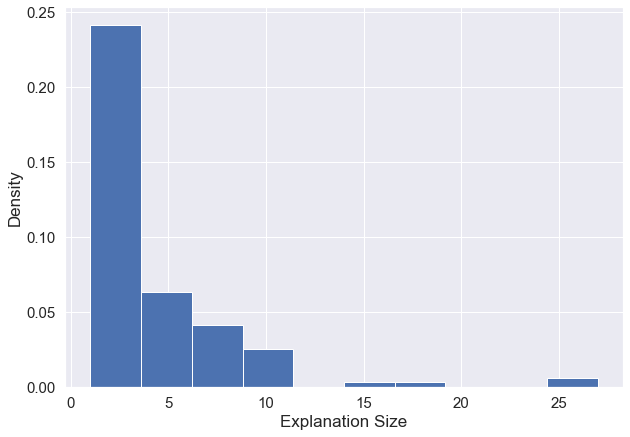

In [14]:
sns.set()

plt.hist(explanation_size_list_syn1, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn1_extension.png', dpi=100)
plt.show()

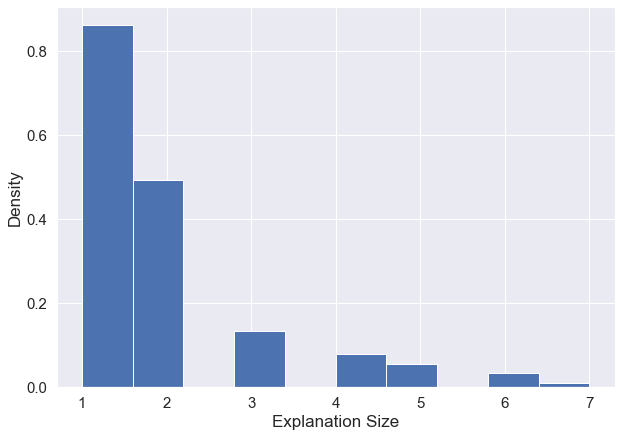

In [15]:
sns.set()

plt.hist(explanation_size_list_syn4,density=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn4_extension.png', dpi=100)
plt.show()

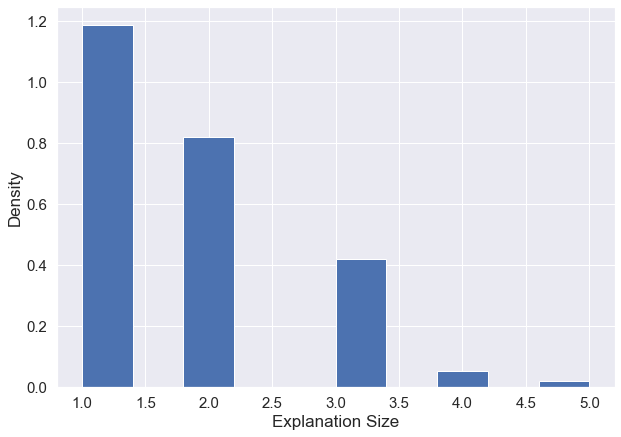

In [16]:
sns.set()

plt.hist(explanation_size_list_syn5, density=True)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn5_extension.png', dpi=100)
plt.show()